In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Load data
df = pd.read_csv("../data/btc_prediction_datawranglingStage.csv")
df.tail()

,Date,open,high,low,close,volume,rsi,ema_long,ema_short,obv,close_nextday
2103,2025-06-11,110274.39,110392.01,108064.00,108645.12,13115.92,58.529152,102270.854128,106231.454684,-1.185512e+06,105671.73
2104,2025-06-12,108645.13,108813.55,105671.72,105671.73,17778.67,50.607683,102404.221810,106178.147572,-1.203291e+06,106066.59
2105,2025-06-13,105671.74,106179.53,102664.31,106066.59,26180.82,51.545554,102547.844092,106167.523041,-1.177110e+06,105414.64
2106,2025-06-14,106066.59,106252.00,104300.00,105414.64,8798.94,49.862067,102660.267461,106095.819894,-1.185909e+06,105594.01
2107,2025-06-15,105414.63,106128.57,104494.53,105594.01,7164.20,50.342600,102775.316188,106048.028476,-1.178745e+06,106390.64


# Data Preprocessing

In [3]:
# Convert date and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
# Create target variable (next day's price change)
df['target'] = df['close_nextday'] - df['close']

In [5]:
# Create technical indicator features
df['ema_crossover'] = np.where(df['ema_short'] > df['ema_long'], 1, -1)
df['rsi_signal'] = np.where(df['rsi'] > 70, -1, np.where(df['rsi'] < 30, 1, 0))
df['obv_pct_change'] = df['obv'].pct_change() * 100

In [6]:
# Lag features to capture momentum
for lag in [1, 2, 3]:
    df[f'rsi_lag_{lag}'] = df['rsi'].shift(lag)
    df[f'obv_lag_{lag}'] = df['obv'].shift(lag)

In [17]:
df.head()

,open,high,low,close,volume,rsi,ema_long,ema_short,obv,close_nextday,target,ema_crossover,rsi_signal,obv_pct_change,rsi_lag_1,obv_lag_1,rsi_lag_2,obv_lag_2,rsi_lag_3,obv_lag_3
Date,,,,,,,,,,,,,,,,,,,,
2019-09-11,10098.19,10293.00,9880.00,10158.33,31953.82,47.202436,10404.317886,10268.563889,194155.907775,10415.01,256.68,-1,0,19.700009,46.031668,162202.083213,49.503392,191117.495438,50.859884,230953.223046
2019-09-12,10158.75,10448.81,10040.00,10415.01,34511.16,51.986726,10404.737185,10282.511137,228667.070530,10342.06,-72.95,-1,0,17.774974,47.202436,194155.907775,46.031668,162202.083213,49.503392,191117.495438
2019-09-13,10415.01,10439.00,10153.00,10342.06,30280.34,50.583805,10402.279256,10288.182458,198386.730754,10335.02,-7.04,-1,0,-13.242108,51.986726,228667.070530,47.202436,194155.907775,46.031668,162202.083213
2019-09-14,10344.13,10419.99,10222.33,10335.02,23621.53,50.442334,10399.641638,10292.643176,174765.197235,10302.01,-33.01,-1,0,-11.906811,50.583805,198386.730754,51.986726,228667.070530,47.202436,194155.907775
2019-09-15,10332.81,10360.00,10252.15,10302.01,18047.65,49.739879,10395.812946,10293.535254,156717.543222,10251.31,-50.70,-1,0,-10.326801,50.442334,174765.197235,50.583805,198386.730754,51.986726,228667.070530


In [7]:
# Remove NaN values
df.dropna(inplace=True)

In [8]:
features = [
    'rsi', 'ema_short', 'ema_long', 'obv', 
    'ema_crossover', 'rsi_signal', 'obv_pct_change',
    'rsi_lag_1', 'rsi_lag_2', 'obv_lag_1'
]

In [9]:
X = df[features]
y = df['target']

In [10]:
# Time-based train-test split (80-20)
split_date = df.index[int(len(df)*0.8)]
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

In [12]:
pipeline.fit(X_train, y_train)

# Generate predictions
y_pred = pipeline.predict(X_test)

# Calculate metrics
print(f"MAE: ${mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

MAE: $1622.71
RMSE: $2193.09
R²: -0.18


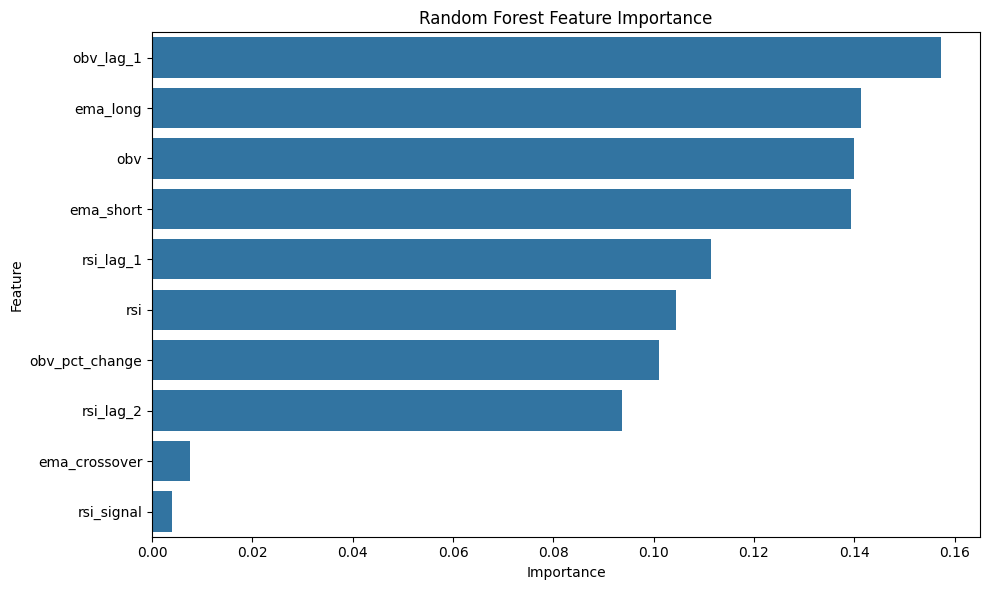

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pipeline.named_steps['rf'].feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

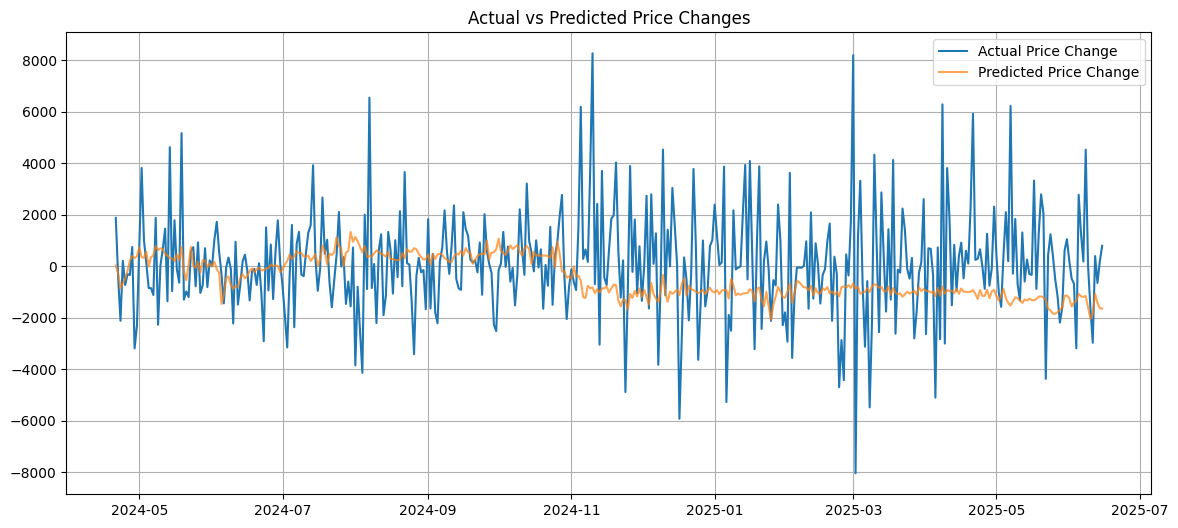

In [15]:
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}, index=y_test.index)

plt.figure(figsize=(14, 6))
plt.plot(results.index, results['Actual'], label='Actual Price Change')
plt.plot(results.index, results['Predicted'], label='Predicted Price Change', alpha=0.7)
plt.title('Actual vs Predicted Price Changes')
plt.legend()
plt.grid()
plt.show()